#import các thư viện cần thiết


In [ ]:
!pip install requests beautifulsoup4

In [ ]:
import requests
from bs4 import BeautifulSoup
import spacy
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# crawl data

In [ ]:
url_en = 'https://www.who.int/news-room/fact-sheets/detail/tuberculosis'

page = requests.get(url_en)
soup = BeautifulSoup(page.text, 'html.parser')

web_content = soup.find_all('div', class_ = "row sf-detail-content")
web_contents = [sen.text.strip() for sen in web_content]
doc = web_contents[1].split('\n')
doc = doc[0]

print(doc)

Key factsA total of 1.25 million people died from tuberculosis (TB) in 2023 (including 161 000 people with HIV). Worldwide, TB has probably returned to being the world’s leading cause of death from a single infectious agent, following three years in which it was replaced by coronavirus disease (COVID-19). It was also the leading killer of people with HIV and a major cause of deaths related to antimicrobial resistance.In 2023, an estimated 10.8 million people fell ill with TB worldwide, including 6.0 million men, 3.6 million women and 1.3 million children. TB is present in all countries and age groups. TB is curable and preventable.Multidrug-resistant TB (MDR-TB) remains a public health crisis and a health security threat. Only about 2 in 5 people with drug resistant TB accessed treatment in 2023.Global efforts to combat TB have saved an estimated 79 million lives since the year 2000.US$ 22 billion is needed annually for TB prevention, diagnosis, treatment and care to achieve the global

# Tách đoạn văn bản

tách đoạn văn bản ra theo từng part

In [ ]:
split_con = [i.text.strip() for i in soup.find_all('h2')]

pattern = '|'.join(map(re.escape, split_con))

corpus = re.split(pattern, doc)

print('real num of topic: ', len(split_con))

print('mum of topic after split: ', len(corpus))

for i in corpus:
  print(i)
  print('-----------------')

real num of topic:  11
mum of topic after split:  14

-----------------
A total of 1.25 million people died from tuberculosis (TB) in 2023 (including 161 000 people with HIV). Worldwide, TB has probably returned to being the world’s leading cause of death from a single infectious agent, following three years in which it was replaced by coronavirus disease (COVID-19). It was also the leading killer of people with HIV and a major cause of deaths related to antimicrobial resistance.In 2023, an estimated 10.8 million people fell ill with TB worldwide, including 6.0 million men, 3.6 million women and 1.3 million children. TB is present in all countries and age groups. TB is curable and preventable.
-----------------
 remains a public health crisis and a health security threat. Only about 2 in 5 people with drug resistant TB accessed treatment in 2023.Global efforts to combat TB have saved an estimated 79 million lives since the year 2000.US$ 22 billion is needed annually for TB prevention, 

=> vấn đề gặp phải từ khóa dùng để tách văn bản bị lập lại ở những phần khác của ngữ cảnh

Xử lí vấn đề và lưu data dưới dạng json

In [ ]:
split_con = [i.text.strip() for i in soup.find_all('h2')]

corpus = []
temp = doc

for topic in range(len(split_con)):
  doc_split = temp.split(split_con[topic], 1)
  temp = doc_split[1]
  if(topic + 1 < len(split_con)):
    doc_split_context = temp.split(split_con[topic + 1], 1)
    context = doc_split[0]
  context = temp
  part = {
      'topic': split_con[topic],
      'context': context
  }
  corpus.append(part)

print(len(corpus))

for part in corpus:
  print(part)

11
{'topic': 'Key facts', 'context': "A total of 1.25\xa0million people died from tuberculosis (TB) in 2023 (including 161\xa0000 people with HIV). Worldwide, TB has probably returned to being the world’s leading cause of death from a single infectious agent, following three years in which it was replaced by coronavirus disease (COVID-19). It was also the leading killer of people with HIV and a major cause of deaths related to antimicrobial resistance.In 2023, an estimated 10.8\xa0million people fell ill with TB worldwide, including 6.0\xa0million men, 3.6\xa0million women and 1.3\xa0million children. TB is present in all countries and age groups. TB is curable and preventable.Multidrug-resistant TB (MDR-TB) remains a public health crisis and a health security threat. Only about 2 in 5 people with drug resistant TB accessed treatment in 2023.Global efforts to combat TB have saved an estimated 79\xa0million lives since the year 2000.US$\xa022\xa0billion is needed annually for TB prevent

chuyển đổi context trong corpus về list để thuận tiện cho việc tiền xử lí

In [ ]:
data = [part['context'] for part in corpus]

print(data)

["A total of 1.25\xa0million people died from tuberculosis (TB) in 2023 (including 161\xa0000 people with HIV). Worldwide, TB has probably returned to being the world’s leading cause of death from a single infectious agent, following three years in which it was replaced by coronavirus disease (COVID-19). It was also the leading killer of people with HIV and a major cause of deaths related to antimicrobial resistance.In 2023, an estimated 10.8\xa0million people fell ill with TB worldwide, including 6.0\xa0million men, 3.6\xa0million women and 1.3\xa0million children. TB is present in all countries and age groups. TB is curable and preventable.Multidrug-resistant TB (MDR-TB) remains a public health crisis and a health security threat. Only about 2 in 5 people with drug resistant TB accessed treatment in 2023.Global efforts to combat TB have saved an estimated 79\xa0million lives since the year 2000.US$\xa022\xa0billion is needed annually for TB prevention, diagnosis, treatment and care t

#pre-procesing

khởi tạo mô hình ngôn ngữ tiếng anh

In [ ]:
nlp = spacy.load("en_core_web_sm")

viết hàm pipeline tiền xử lí

In [ ]:
unwanted_pipes = ["ner", "parser"]

def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if not t.is_punct and not t.is_space and t.is_alpha]

chuyển về ma trận

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

matrix = vectorizer.fit_transform(data)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
print(matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3684 stored elements and shape (11, 506)>
  Coords	Values
  (0, 0)	0.11141729308912317
  (0, 458)	0.024237293225709666
  (0, 298)	0.27674658951016895
  (0, 275)	0.06665255637070158
  (0, 319)	0.12724578943497575
  (0, 128)	0.013198578589793208
  (0, 181)	0.0668503758534739
  (0, 469)	0.01735454473180456
  (0, 436)	0.42024482110803435
  (0, 215)	0.2254972210823599
  (0, 217)	0.030749621056685442
  (0, 493)	0.16399797896898902
  (0, 201)	0.08483052628998383
  (0, 499)	0.028615181920058658
  (0, 196)	0.07877120298355642
  (0, 339)	0.014307590960029329
  (0, 378)	0.014307590960029329
  (0, 456)	0.220372284239579
  (0, 52)	0.2972463368812926
  (0, 443)	0.33312089478075896
  (0, 498)	0.012118646612854833
  (0, 244)	0.026397157179586416
  (0, 76)	0.03959573576937963
  (0, 115)	0.030296616532137086
  (0, 398)	0.014307590960029329
  :	:
  (10, 460)	0.03477340712103605
  (10, 135)	0.03477340712103605
  (10, 291)	0.03477340712103605
  

# Giảm chiều matrix để biểu diễn

In [ ]:
pca = PCA(n_components=2)

matrix2d = pca.fit_transform(matrix.toarray())

print(matrix2d)

[[-0.2124086  -0.10271448]
 [-0.20497975 -0.11601797]
 [-0.18330384 -0.08926539]
 [-0.16192112 -0.04941211]
 [-0.14084349  0.01409103]
 [-0.11736812  0.05523066]
 [-0.07521564  0.09234132]
 [ 0.06393194  0.18852677]
 [ 0.17824164  0.18865083]
 [ 0.35398683  0.06535322]
 [ 0.49988016 -0.24678387]]


# Biến đổi về dataframe

scaler

In [ ]:
scaler = MinMaxScaler()

scaler.fit_transform(matrix2d)

matrix2d_scaled = scaler.transform(matrix2d)

print(matrix2d_scaled)

[[0.         0.33086337]
 [0.01042955 0.30031116]
 [0.0408609  0.36174995]
 [0.07088064 0.45327523]
 [0.10047206 0.59911372]
 [0.1334297  0.69359318]
 [0.19260863 0.77881986]
 [0.3879614  0.99971508]
 [0.54844365 1.        ]
 [0.79517672 0.71684018]
 [1.         0.        ]]


In [ ]:
df = pd.DataFrame(matrix2d_scaled)

df['topic'] = [part['topic'] for part in corpus]

print(df)

           0         1                            topic
0   0.000000  0.330863                        Key facts
1   0.010430  0.300311                         Overview
2   0.040861  0.361750                         Symptoms
3   0.070881  0.453275                       Prevention
4   0.100472  0.599114                        Diagnosis
5   0.133430  0.693593                        Treatment
6   0.192609  0.778820  Multidrug-resistant TB (MDR-TB)
7   0.387961  0.999715                       TB and HIV
8   0.548444  1.000000                           Impact
9   0.795177  0.716840            Investments to end TB
10  1.000000  0.000000                     WHO response


# Tạo model Kmean để phân cụm

In [ ]:
n_cluster = 3

Kmean = KMeans(n_clusters = n_cluster, random_state = 42)

label = Kmean.fit_predict(matrix2d_scaled)

print(label)

[2 2 2 2 2 2 0 0 0 0 1]


Thêm label vào df

In [ ]:
df['label'] = label
print(df)

           0         1                            topic  label
0   0.000000  0.330863                        Key facts      2
1   0.010430  0.300311                         Overview      2
2   0.040861  0.361750                         Symptoms      2
3   0.070881  0.453275                       Prevention      2
4   0.100472  0.599114                        Diagnosis      2
5   0.133430  0.693593                        Treatment      2
6   0.192609  0.778820  Multidrug-resistant TB (MDR-TB)      0
7   0.387961  0.999715                       TB and HIV      0
8   0.548444  1.000000                           Impact      0
9   0.795177  0.716840            Investments to end TB      0
10  1.000000  0.000000                     WHO response      1


# trực quan hóa

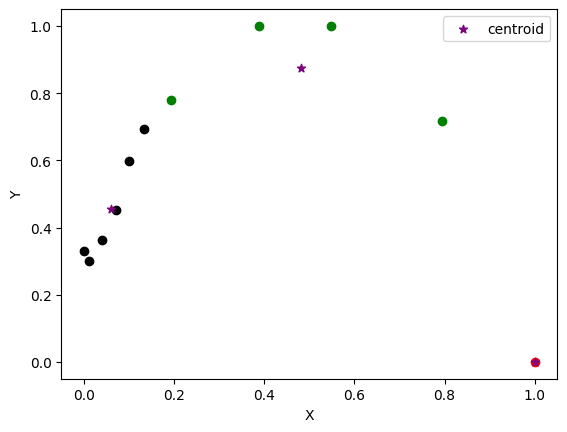

In [ ]:
df1 = df[df.label == 0]
df2 = df[df.label == 1]
df3 = df[df.label == 2]

plt.scatter(df1[0], df1[1], color = 'green')
plt.scatter(df2[0], df2[1], color = 'red')
plt.scatter(df3[0], df3[1], color = 'black')

plt.scatter(Kmean.cluster_centers_[:,0], Kmean.cluster_centers_[:, 1], color = 'purple', marker = '*', label = 'centroid')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()